In [1]:
import numpy as np
import matplotlib.pylab as plt
from scipy import stats
from statsmodels.stats.descriptivestats import sign_test
from statsmodels.stats.weightstats import zconfint
import itertools

In [2]:
survive = [49,58,75,110,112,132,151,276,281,362]
survive = np.array(survive)
week = list(range(1, len(survive) + 1))

\begin{equation}
H_0: med{X} = 200
\end{equation}

\begin{equation}
H_1: med{X} \neq 200
\end{equation}

<BarContainer object of 10 artists>

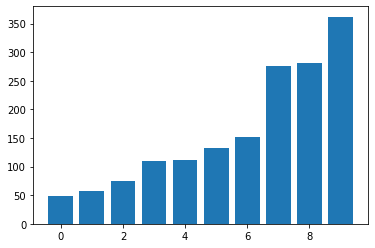

In [3]:
plt.bar(range(len(survive)), survive)

In [4]:
median = 200
round(stats.wilcoxon(survive - median, mode='approx')[1],4)

0.2845

In [5]:
forest_natural = np.array([22,22,15,13,19,19,18,20,21,13,13,15])
forest_humanity = np.array([17,18,18,15,12,4,14,15,10])

\begin{equation}
H_0: F_{X_1}(x) = F_{X_2}(x)
\end{equation}

\begin{equation}
H_1: F_{X_1}(x) = F_{X_2}(x + \Delta)
\end{equation}

In [6]:
round(stats.mannwhitneyu(forest_humanity, forest_natural, alternative='less')[1],4)

0.029

28 января 1986 года космический шаттл "Челленджер" взорвался при взлёте. Семь астронавтов, находившихся на борту, погибли. В ходе расследования причин катастрофы основной версией была неполадка с резиновыми уплотнительными кольцами в соединении с ракетными ускорителями. Для 23 предшествовавших катастрофе полётов "Челленджера" известны температура воздуха и появление повреждений хотя бы у одного из уплотнительных колец.

С помощью бутстрепа постройте 95% доверительный интервал для разности средних температур воздуха при запусках, когда уплотнительные кольца повреждались, и запусках, когда повреждений не было. Чему равна его ближайшая к нулю граница? Округлите до четырёх знаков после запятой.

Чтобы получить в точности такой же доверительный интервал, как у нас:

установите random seed = 0 перед первым вызовом функции get_bootstrap_samples, один раз
сделайте по 1000 псевдовыборок из каждой выборки.

In [7]:
import pandas as pd

In [8]:
challenger_data = pd.read_csv("challenger.txt", header=0, sep='\t')
challenger_data.columns = ['Date', 'Temperature', 'Incident']
challenger_data.head()

,Date,Temperature,Incident
0,Apr12.81,18.9,0
1,Nov12.81,21.1,1
2,Mar22.82,20.6,0
3,Nov11.82,20.0,0
4,Apr04.83,19.4,0


In [19]:
challenger_damage = challenger_data[challenger_data['Incident'] == 1].Temperature.values
challenger_clean = challenger_data[challenger_data['Incident'] == 0].Temperature.values
print('Shape clean:', challenger_clean.shape)
print('Shape damage:', challenger_damage.shape)

Shape clean: (16,)
Shape damage: (7,)


In [10]:
print('Clean:', zconfint(challenger_clean))
print('Damage:', zconfint(challenger_damage))
#   Совсем немного пересекаются

Clean: (20.961457789002573, 23.601042210997427)
Damage: (14.258978339107285, 20.969593089464148)


In [28]:
np.random.seed(0)
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), size=(n_samples, len(data)))
    sample = data[indices]
    return sample

def stat_intervals(stat, alpha=.05):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

clean_median = list(map(np.mean, get_bootstrap_samples(challenger_clean, 1000)))
damage_median = list(map(np.mean, get_bootstrap_samples(challenger_damage, 1000)))
print('CLEAN:', stat_intervals(clean_median))
print('DAMAGE:', stat_intervals(damage_median))

print('SUBTRACT:', stat_intervals(np.array(clean_median) - np.array(damage_median)))

CLEAN: [21.06875  23.575625]
DAMAGE: [14.5125     20.71607143]
SUBTRACT: [1.42299107 7.93861607]


-4.666964285714283


0.0057

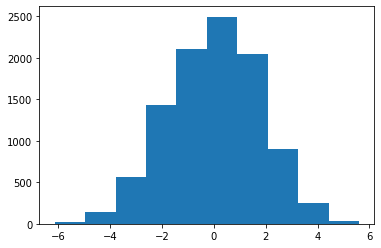

In [35]:
import itertools
def samples_test(sample, mean, max_permutations=None, alternative='two-sided'):
    if alternative not in ('two-sided', 'greater', 'less'):
        raise ValueError('Unknown Alternative')
    t_stat = get_t_stat_permutations(sample, mean)
    print(t_stat)
    zero_distr = get_zero_distr(sample, mean, max_permutations)
    plt.hist(zero_distr)
    if alternative == 'two-sided':
        return sum([1. if abs(x) >= abs(t_stat) else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'greater':
        return sum([1. if x >= t_stat else 0. for x in zero_distr]) / len(zero_distr)

    if alternative == 'less':
        return sum([1. if x <= t_stat else 0. for x in zero_distr]) / len(zero_distr)

def get_t_stat_permutations(sample, sample2):
    return np.mean(sample) - np.mean(sample2)

def get_zero_distr(sample1, sample2, max_permutations=None):
    joined_sample = np.hstack((sample1, sample2))
    n1 = len(sample1)
    n = len(joined_sample)
    if max_permutations:
        indices = create_combinations(n1, len(sample2), max_permutations)
    else:
        indices = [(list(buffer), list(filter(lambda i: i not in buffer, range(n)))) for buffer in itertools.combinations(range(n), n1)]
    distr = [joined_sample[list(i[0])].mean() - joined_sample[list(i[1])].mean() for i in indices]
    return distr

def create_combinations(n1, n2, max_permutations):
    index = list(range(n1 + n2))
    indices = set([tuple(index)])
    for i in range(max_permutations - 1):
        np.random.shuffle(index)
        indices.add(tuple(index))
    return [(index[:n1], index[n1:]) for index in indices]

np.random.seed(0)
samples_test(challenger_damage, challenger_clean, max_permutations=10000, alternative='two-sided')